In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter, get_scada_subset, get_weather_subset
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [41]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [4]:
# New data from march to check confidence intervals
start_test =  datetime.datetime(2023,3,1,tzinfo=utc)
stop_test  = datetime.datetime(2023,4,1,tzinfo=utc)

# Get mvbc data
mvbc_username = os.getenv('MEETNET_USERNAME') # Replace with your usernam
mvbc_password = os.getenv('MEETNET_PASSWORD') # Replace with your password
creds = Credentials(username=mvbc_username, password=mvbc_password)
b=Base(creds)
b.ping()
c = Catalog(credentials=creds)
df_unfiltered = c.data_points()
weather_station = 'Wandelaar'
mvbc_test_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start_test,
        stop_test,
        creds,
        df_unfiltered
    )
mvbc_test_data = mvbc_test_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

# Get API data
dsg = DatasetGetter(
    start_test,
    stop_test,
    location)
dsg.get_longterm_data()
test_data = dsg.data

In [5]:
mpe_test_data = data.filter(regex='mpe')
mpe_test_FA = \
    pd.DataFrame.from_records(
        mpe_test_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_test_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().index
        )
mpe_test_SS = \
    pd.DataFrame.from_records(
        mpe_test_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_test_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().index
        )

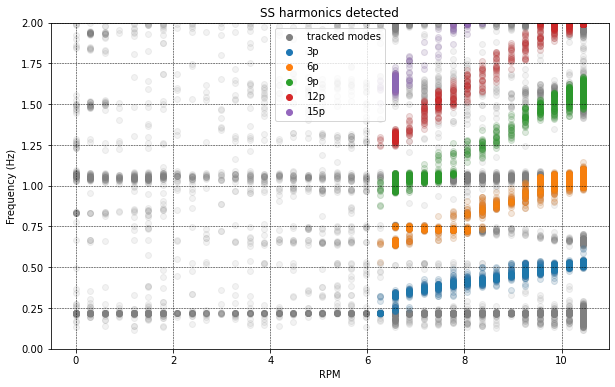

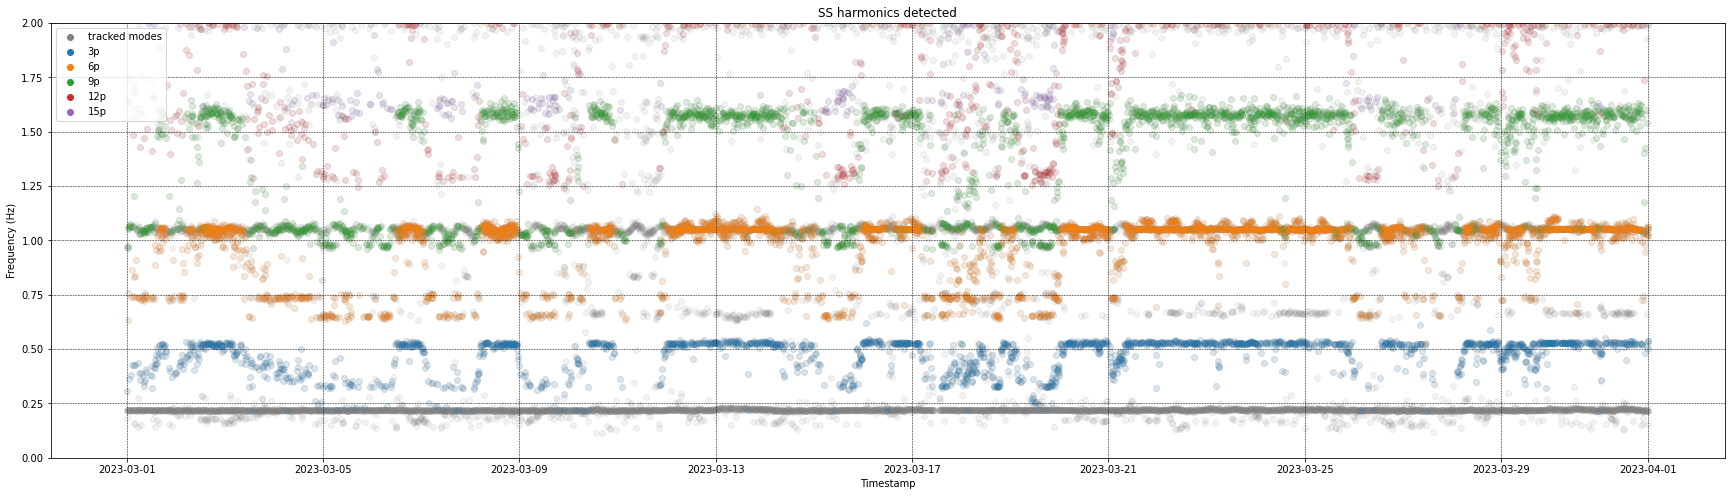

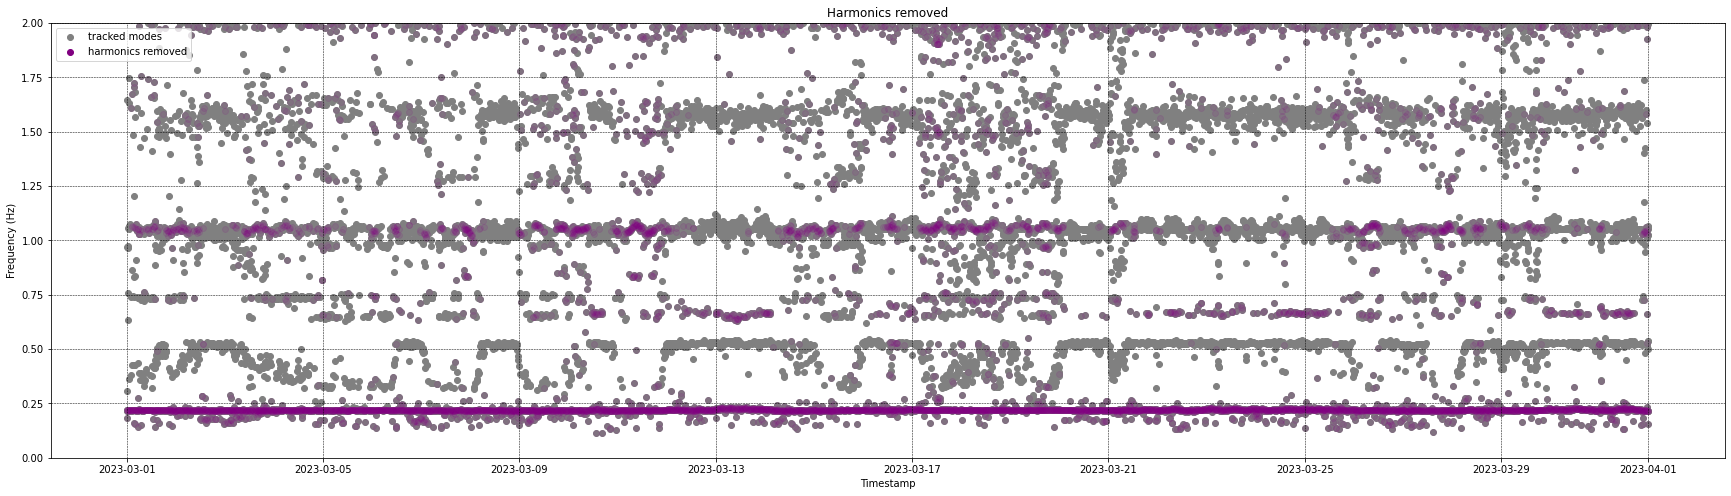

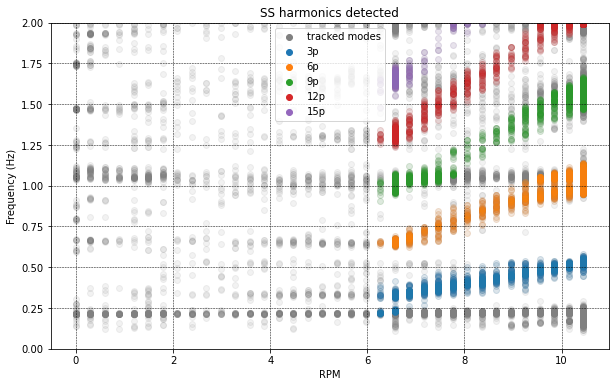

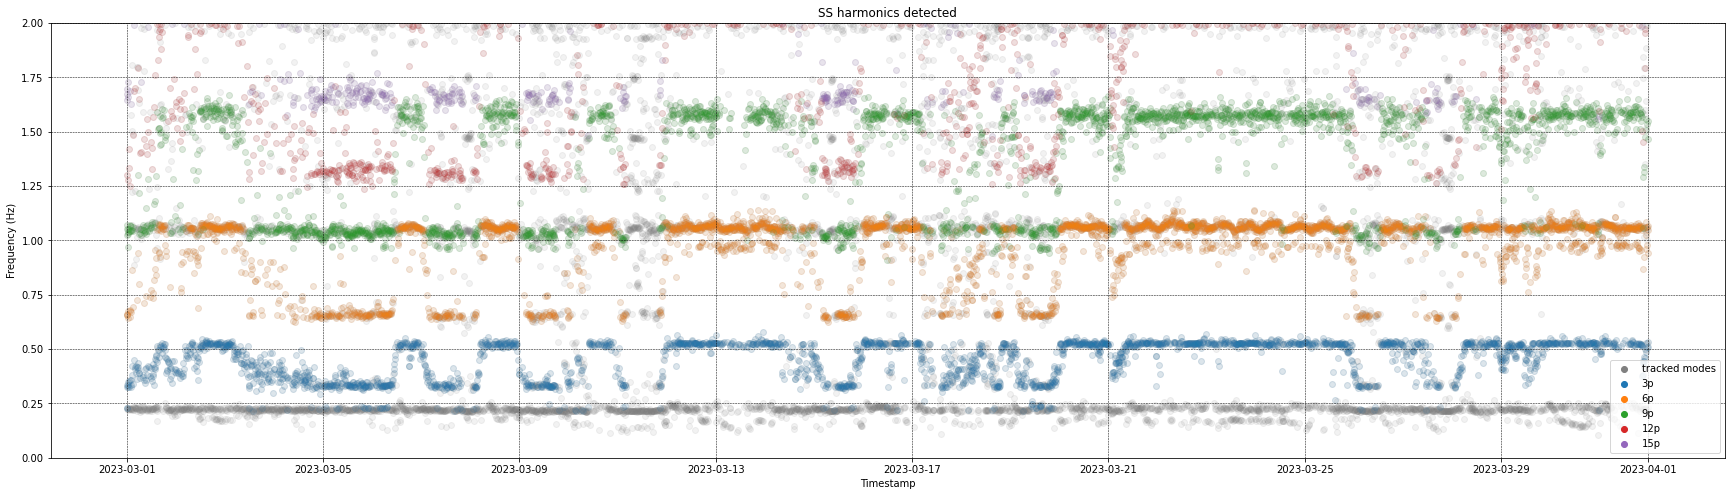

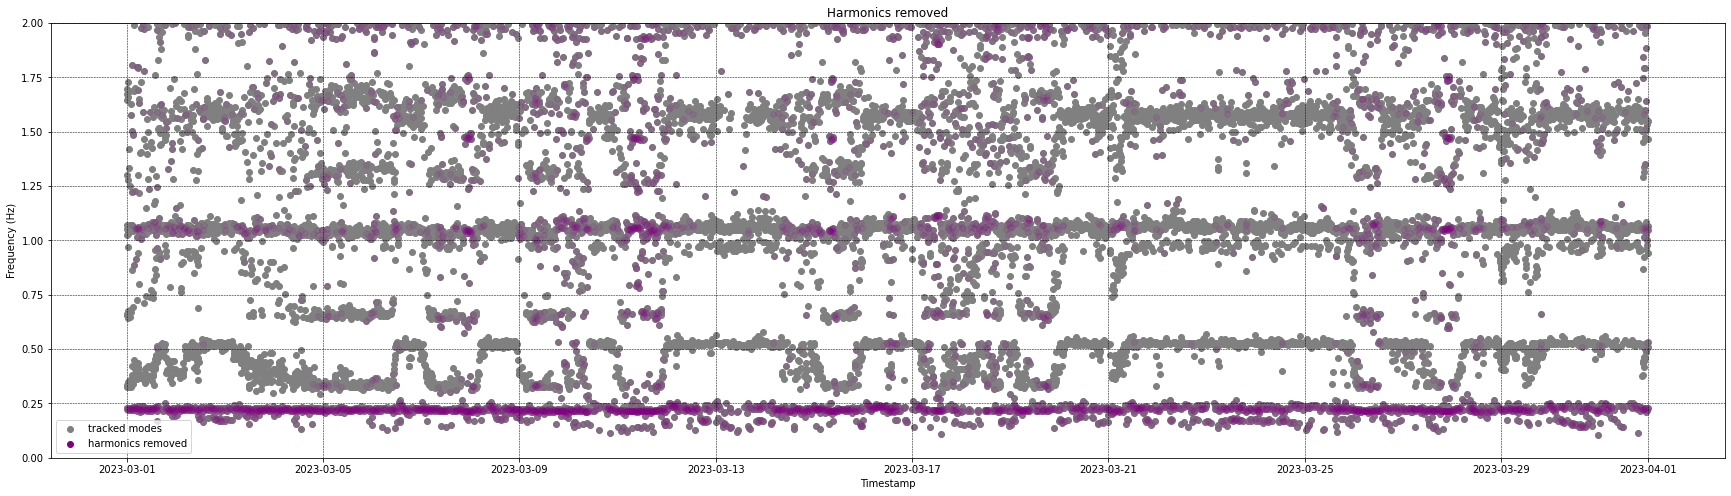

In [6]:
from oma_tracking.data.make_dataset import get_mpe_data
from oma_tracking.modal_tracking.harmonics import HarmonicDetector

clustering_data = {}
mpe_test_data = {}
harmonic_detectors = {}
harmonics_removed = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_test_data[direction] = get_mpe_data(test_data, direction, name_location)
    clustering_data[direction] = mpe_test_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
    harmonic_detectors[direction] = HarmonicDetector(test_data, clustering_data[direction], p_orders=[3,6,9,12, 15])
    distance_calculator_data = harmonic_detectors[direction].get_distance_calculator_data()
    harmonic_detectors[direction].plot_distances()
    harmonic_detectors[direction].plot_harmonics_removed()
    harmonics_removed[direction] = harmonic_detectors[direction].remove_harmonics()


In [7]:
mc = {}
clustered_modes = {}

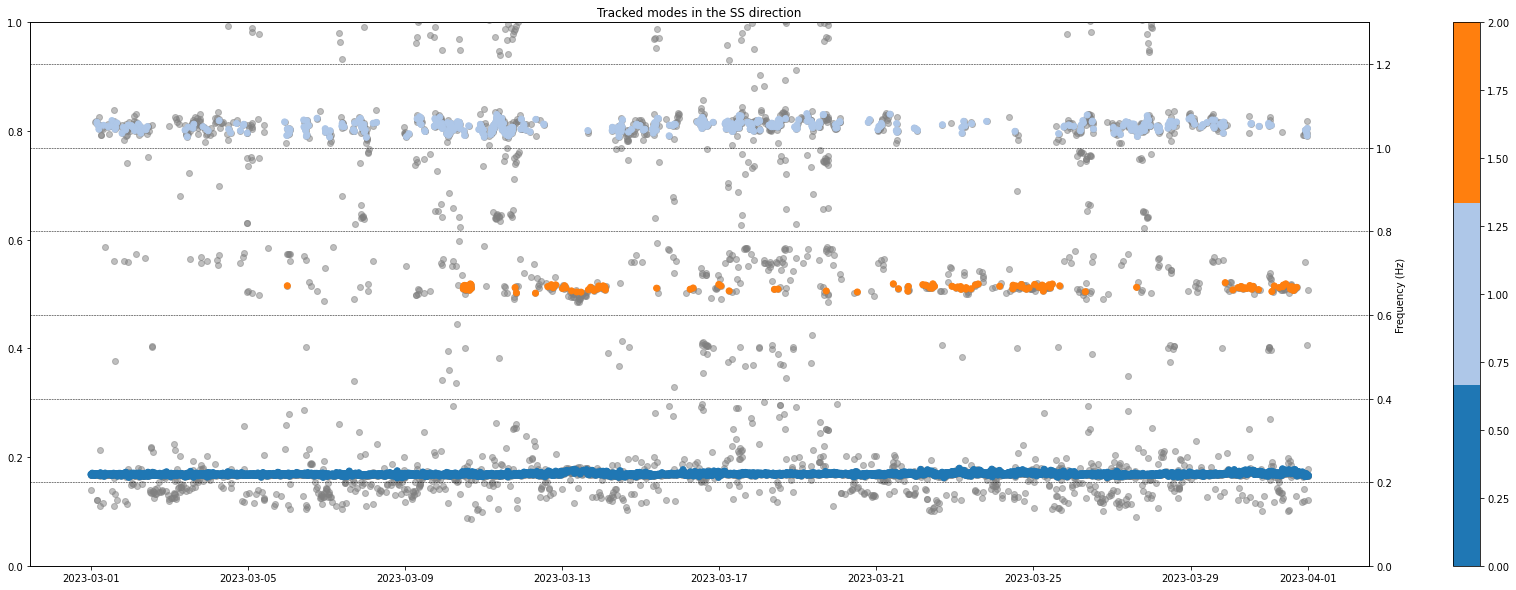

In [8]:

direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=100)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)

plt.show()

SS1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS1_harmonics_removed = SS1_harmonics_removed[~SS1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 1]
SS2_harmonics_removed = SS2_harmonics_removed[~SS2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

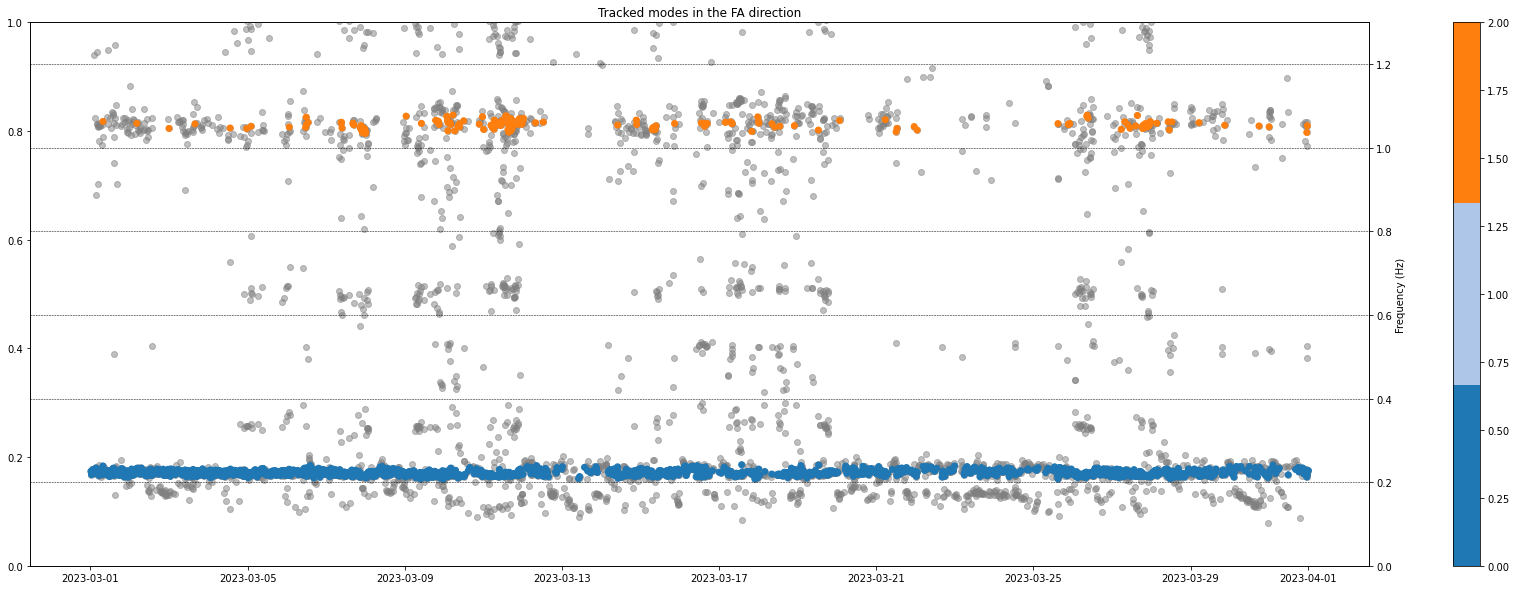

In [9]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=100)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the ' + direction + ' direction')
plt.ylim(0, 1.3)

plt.show()

FA1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
FA1_harmonics_removed = FA1_harmonics_removed[~FA1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
FA2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 2]
FA2_harmonics_removed = FA2_harmonics_removed[~FA2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

In [10]:
tracked_frequencies_hamonics_removed_test = \
    pd.DataFrame(
        {
            'SS1': SS1_harmonics_removed['frequency'],
            'SS2': SS2_harmonics_removed['frequency'],
            'FA1': FA1_harmonics_removed['frequency'],
            'FA2': FA2_harmonics_removed['frequency'],
        }
    )

## Power Analysis

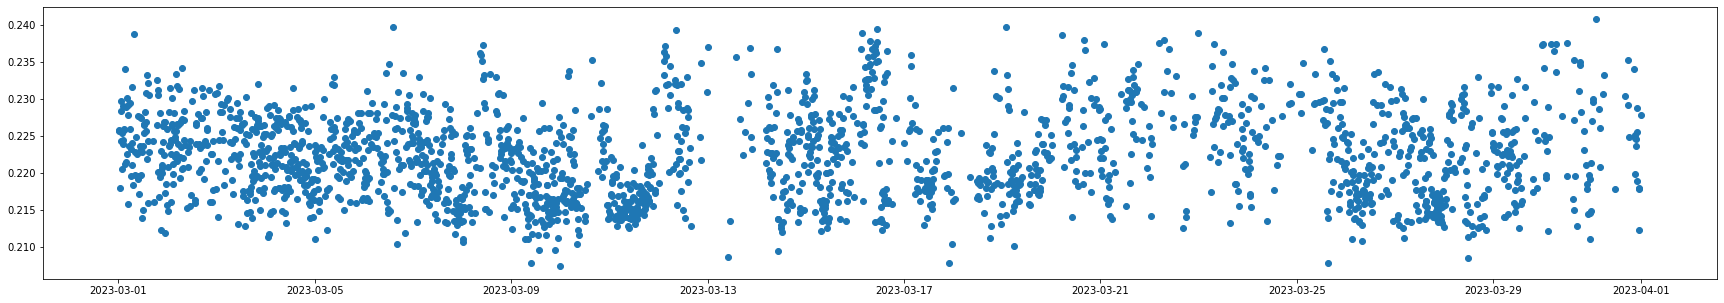

In [92]:
plt.figure(figsize=(30,5))
plt.scatter(tracked_frequencies_hamonics_removed_test['FA1'].index, tracked_frequencies_hamonics_removed_test['FA1'])

In [102]:
simulation_shifts

{'parked_scour':             SS1       FA1       SS2       FA2
 0.05D  0.127630  0.129430  0.304177  0.349048
 0.1D   0.505071  0.512128  1.182929  1.351545
 0.2D   0.718151  0.728136  1.669114  1.902939
 0.3D   1.132493  1.148117  2.613908  2.969391
 0.4D   1.648498  1.671038  3.780256  4.276558
 0.5D   2.191268  2.220945  4.989751  5.621893
 0.6D   2.736351  2.773059  6.186122  6.942979
 0.7D   3.202670  3.245277  7.191710  8.046403
 0.8D   3.577377  3.624656  7.992412  8.920836,
 'rated_scour':             SS1       FA1       SS2       FA2
 0.05D  0.196027  0.198684  0.458641  0.514441
 0.1D   0.505285  0.512088  1.170183  1.309303
 0.2D   0.877346  0.889085  2.025021  2.260421
 0.3D   1.219482  1.235700  2.802684  3.121827
 0.4D   1.201659  1.217926  2.985550  3.335709
 0.5D   1.591487  1.612790  3.856695  4.294776
 0.6D   1.759168  1.782738  4.326537  4.815361
 0.7D   2.429208  2.461022  5.631560  6.232376
 0.8D   2.756961  2.792787  6.301577  6.958963}

In [100]:
from statsmodels.stats.power import Power
from statsmodels.stats.power import TTestIndPower
from matplotlib import pyplot as plt
power = 0.99
significance = 0.01
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
modes = ['SS1', 'SS2', 'FA1', 'FA2']
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = tracked_frequencies_hamonics_removed_test[mode]
        scour_population = \
            tracked_frequencies_hamonics_removed_test[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *tracked_frequencies_hamonics_removed_test[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  4530.731882475742 , in days:  31.46
0.1D  nr of samples:  290.8724161215969 , in days:  2.02
0.2D  nr of samples:  144.71946779429211 , in days:  1.0
0.3D  nr of samples:  59.21220148116358 , in days:  0.41
0.4D  nr of samples:  28.868936365581696 , in days:  0.2
SS2
0.05D  nr of samples:  577.9421835121875 , in days:  4.01
0.1D  nr of samples:  39.80749780689512 , in days:  0.28
0.2D  nr of samples:  20.88373269180683 , in days:  0.15
0.3D  nr of samples:  9.649754000495289 , in days:  0.07
0.4D  nr of samples:  5.698613346983199 , in days:  0.04
FA1
0.05D  nr of samples:  21004.727925551026 , in days:  145.87
0.1D  nr of samples:  1343.1710188913696 , in days:  9.33
0.2D  nr of samples:  665.2918069513847 , in days:  4.62
0.3D  nr of samples:  268.5840636885676 , in days:  1.87
0.4D  nr of samples:  127.67501062981324 , in days:  0.89
FA2
0.05D  nr of samples:  338.98368246033885 , in days:  2.35
0.1D  nr of samples:  24.231357104607053 , in days:  0.17
0.2

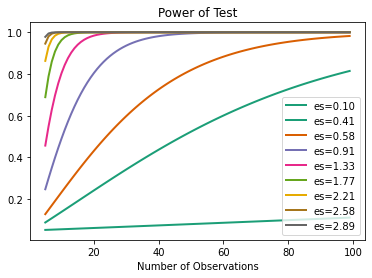

In [64]:
import numpy as np
operating_condition = 'parked'
mode = 'SS1'
effect_sizes = []

# parameters for power analysis
for scouring_scenario in simulation_shifts[operating_condition + '_scour'][mode].index:
    normal_population = tracked_frequencies_hamonics_removed_test[mode]
    scour_population = \
        tracked_frequencies_hamonics_removed_test[mode] \
        - (
            simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
            *tracked_frequencies_hamonics_removed_test[mode]
        )
    effect_size = (normal_population.mean() - scour_population.mean()) / normal_population.std()
    effect_sizes.append(effect_size)

effect_sizes = np.array(effect_sizes)
sample_sizes = np.array(range(5, 100))

power_analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [101]:
simulation_shifts

{'parked_scour':             SS1       FA1       SS2       FA2
 0.05D  0.127630  0.129430  0.304177  0.349048
 0.1D   0.505071  0.512128  1.182929  1.351545
 0.2D   0.718151  0.728136  1.669114  1.902939
 0.3D   1.132493  1.148117  2.613908  2.969391
 0.4D   1.648498  1.671038  3.780256  4.276558
 0.5D   2.191268  2.220945  4.989751  5.621893
 0.6D   2.736351  2.773059  6.186122  6.942979
 0.7D   3.202670  3.245277  7.191710  8.046403
 0.8D   3.577377  3.624656  7.992412  8.920836,
 'rated_scour':             SS1       FA1       SS2       FA2
 0.05D  0.196027  0.198684  0.458641  0.514441
 0.1D   0.505285  0.512088  1.170183  1.309303
 0.2D   0.877346  0.889085  2.025021  2.260421
 0.3D   1.219482  1.235700  2.802684  3.121827
 0.4D   1.201659  1.217926  2.985550  3.335709
 0.5D   1.591487  1.612790  3.856695  4.294776
 0.6D   1.759168  1.782738  4.326537  4.815361
 0.7D   2.429208  2.461022  5.631560  6.232376
 0.8D   2.756961  2.792787  6.301577  6.958963}

SS1
   scour  effect size
0  0.05D     0.103015
1   0.1D     0.407661
2   0.2D     0.579646
3   0.3D     0.914076
4   0.4D     1.330562


<Figure size 1440x360 with 0 Axes>

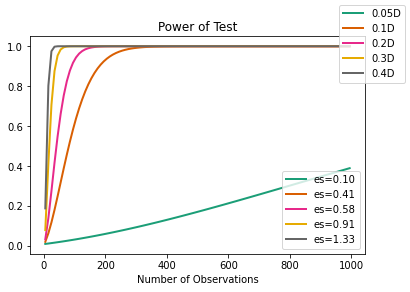

SS2
   scour  effect size
0  0.05D     0.288793
1   0.1D     1.123104
2   0.2D     1.584701
3   0.3D     2.481714
4   0.4D     3.589075


<Figure size 1440x360 with 0 Axes>

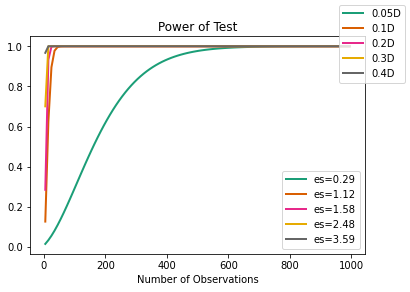

FA1
   scour  effect size
0  0.05D     0.047837
1   0.1D     0.189281
2   0.2D     0.269117
3   0.3D     0.424341
4   0.4D     0.617611


<Figure size 1440x360 with 0 Axes>

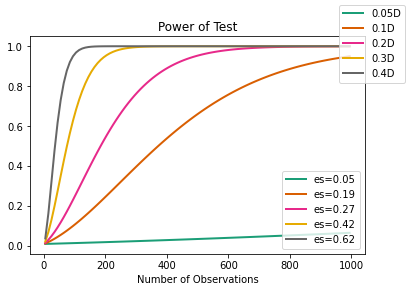

FA2
   scour  effect size
0  0.05D     0.377471
1   0.1D     1.461600
2   0.2D     2.057893
3   0.3D     3.211186
4   0.4D     4.624794


<Figure size 1440x360 with 0 Axes>

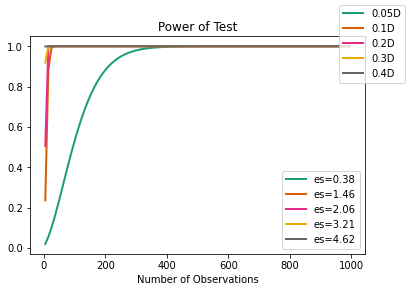

In [79]:
import numpy as np
operating_condition = 'parked'
alpha = 0.01 # significance level
for mode in ['SS1', 'SS2', 'FA1', 'FA2']:
    print(mode)
    effect_sizes = []
    scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
    # parameters for power analysis
    for scouring_scenario in scouring_scenarios:
        normal_population = tracked_frequencies_hamonics_removed_test[mode]
        scour_population = \
            tracked_frequencies_hamonics_removed_test[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *tracked_frequencies_hamonics_removed_test[mode]
            )
        effect_size = (normal_population.mean() - scour_population.mean()) / normal_population.std()
        effect_sizes.append(effect_size)

    effect_sizes = np.array(effect_sizes)
    sample_sizes = np.array(range(5, 1000, 10))

    power_analysis = TTestIndPower()
    plt.figure(figsize=(20, 5))
    fig = power_analysis.plot_power(alpha= alpha, dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
    fig.legend(scouring_scenarios)
    print(pd.DataFrame({'scour': scouring_scenarios, 'effect size': effect_sizes}))
    plt.show()

In [96]:
import numpy as np
from scipy.stats import norm, mannwhitneyu

def MWPpower(n1, n2, effect_size, alpha, power):
    # calculate the critical value for the test
    z_alpha = norm.ppf(1 - alpha / 2)
    
    # calculate the non-centrality parameter
    delta = effect_size * np.sqrt((n1 * n2) / (n1 + n2))
    
    # set the initial sample size
    m = 10
    
    while True:
        # calculate the critical value for the given sample size
        u_alpha = \
            mannwhitneyu(training_data, training)
                              
        u_alpha -= (n1 * n2) / 2
        
        # calculate the power for the given sample size
        power_m = 1 - norm.cdf((z_alpha - np.sqrt(m) * delta - u_alpha) / np.sqrt(1 + m / n1 + m / n2))
        
        # check if the desired power is reached
        if power_m >= power:
            return m
        
        # increment the sample size
        m += 10


In [ ]:
MWPpower(n1, n2, effect_size, alpha, power)

In [97]:
from statsmodels.stats.power import Power
from statsmodels.stats.power import TTestIndPower
from matplotlib import pyplot as plt
power = 0.8
significance = 0.01
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
modes = ['SS1', 'SS2', 'FA1', 'FA2']
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = tracked_frequencies_hamonics_removed_test[mode]
        scour_population = \
            tracked_frequencies_hamonics_removed_test[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *tracked_frequencies_hamonics_removed_test[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (2*normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = MWPpower(100, 100, effect_size=effect_size, alpha=significance, power=power)
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  20 , in days:  0.14
0.1D  nr of samples:  10 , in days:  0.07
0.2D  nr of samples:  570 , in days:  3.96
0.3D  nr of samples:  4410 , in days:  30.62
0.4D  nr of samples:  14790 , in days:  102.71
SS2
0.05D  nr of samples:  20 , in days:  0.14
0.1D  nr of samples:  8460 , in days:  58.75
0.2D  nr of samples:  36750 , in days:  255.21
0.3D  nr of samples:  67050 , in days:  465.62
0.4D  nr of samples:  70800 , in days:  491.67
FA1
0.05D  nr of samples:  20 , in days:  0.14
0.1D  nr of samples:  40 , in days:  0.28
0.2D  nr of samples:  20 , in days:  0.14
0.3D  nr of samples:  70 , in days:  0.49
0.4D  nr of samples:  20 , in days:  0.14
FA2
0.05D  nr of samples:  10 , in days:  0.07
0.1D  nr of samples:  6920 , in days:  48.06
0.2D  nr of samples:  36290 , in days:  252.01
0.3D  nr of samples:  63570 , in days:  441.46
0.4D  nr of samples:  64020 , in days:  444.58


In [ ]:
import numpy as np
from statsmodels.stats.power import Power

def rated_std(data1: pd.DataFrame, data2: pd.DataFrame, ):
    return np.sqrt((data1 - data2).std()**2 + (data1 - data2).mean()**2)

def calculate_effect_size(data1: pd.DataFrame, data2: pd.DataFrame):
    """Calculate the effect size of the difference between two datasets.
    In our case, the effect size is the difference between the means of the two datasets

    Args:
        data1 (pd.DataFrame): _description_
        data2 (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """    
    return (data1.mean() - data2.mean())/rated_std(data1, data2)

def power_analysis(
    data: pd.DataFrame,
    shifted_data: pd.DataFrame,
    power = 0.8: float,
    significance = 0.05: float,
    effect_size = None: float
    ) -> int:
    """Power analysis to determine the sample size required
    to detect a difference between two datasets.
    H0: The two datasets are sampled from the same distribution.
        (= No shift in the data.)
    H1: The two datasets are sampled from different distributions.
    Reject H0 if the p-value is less than the significance level.
    H0 has a probability of correctly being rejected of power.
    Power = 1 - Type II Error
    Pr(True Positive) = 1 - Pr(False Negative)

    Args:
        data (pd.DataFrame): _description_
        shifted_data (pd.DataFrame): _description_
        power (float): _description_
        significance (float): _description_
    
    Returns:
        int: _description_
    """    
    if effect_size is None:
        effect_size = calculate_effect_size(data, shifted_data)
    # Create a Power object and perform the power analysis
    power_analysis = Power().solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
    required_sample_size = power_analysis.round()
    return required_sample_size
    


## Confidence intervals

In [11]:
import numpy as np 
from scipy.stats import t
from scipy.stats import norm

In [12]:
training_mean = np.mean(tracked_frequencies)
training_std = np.std(tracked_frequencies)

test_mean = np.mean(tracked_frequencies_hamonics_removed_test)
test_std = np.std(tracked_frequencies_hamonics_removed_test)

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [13]:
confidence = 0.01
dof = len(tracked_frequencies)-1 
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
(training_mean-training_std*t_crit/np.sqrt(len(tracked_frequencies)), training_mean+training_std*t_crit/np.sqrt(len(tracked_frequencies))) 

(SS1    0.219388
 SS2    1.058735
 FA1    0.222785
 FA2    1.059004
 dtype: float64,
 SS1    0.219388
 SS2    1.058738
 FA1    0.222787
 FA2    1.059006
 dtype: float64)

In [14]:
confidence = 0.95
dof = len(tracked_frequencies)-1 
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
(training_mean-training_std*t_crit/np.sqrt(len(tracked_frequencies)), training_mean+training_std*t_crit/np.sqrt(len(tracked_frequencies))) 

(SS1    0.219348
 SS2    1.058541
 FA1    0.222689
 FA2    1.058835
 dtype: float64,
 SS1    0.219428
 SS2    1.058932
 FA1    0.222883
 FA2    1.059176
 dtype: float64)

In [22]:
from scipy.stats import ks_2samp, ranksums, wasserstein_distance, anderson_ksamp, mannwhitneyu


def ks_sample_required(training_data, significance, n_min):
    training_data.dropna(inplace=True)
    n = n_min
    while n < len(training_data):
        p_val_max = 0
        i = 0
        while i < len(training_data)-(n+1):
            ks_stat, p_val = \
                ks_2samp(
                    pd.concat([
                        training_data.iloc[0:i],
                        training_data.iloc[i+n: -1]
                    ]),
                    training_data.iloc[i:i+n])
            i += n
            p_val_max = max(p_val_max, p_val)
        if p_val_max < significance:
            print(p_val_max)
            print(n/144, ' days of data required for all amples to have a pvalue < ', significance, ', here max p-value = ', p_val_max)
            return n
        else:
            n += n_min
    return n

In [23]:
for direction in ['SS1', 'SS2', 'FA1', 'FA2']:
    print(direction)
    ks_sample_required(tracked_frequencies[direction], 0.01, 144)

SS1
0.0018927149775262643
11.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  0.0018927149775262643
SS2
0.0003210961713993535
7.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  0.0003210961713993535
FA1
0.0004768082915244996
19.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  0.0004768082915244996
FA2
0.006083810902224292
6.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  0.006083810902224292


In [24]:
for direction in ['SS1', 'SS2', 'FA1', 'FA2']:
    print(direction)
    ks_sample_required(tracked_frequencies[direction], 0.05, 144)

SS1
0.0018927149775262643
11.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  0.0018927149775262643
SS2
0.0003210961713993535
7.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  0.0003210961713993535
FA1
0.033943965985074646
13.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  0.033943965985074646
FA2
0.006083810902224292
6.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  0.006083810902224292


In [25]:
from scipy.stats import mannwhitneyu


def mwu_sample_required(training_data, significance, n_min):
    training_data.dropna(inplace=True)
    n = n_min
    while n < len(training_data):
        i = 0
        p_val_max = 0
        while i < len(training_data)-(n+1):
            mwu_stat, p_val = \
                mannwhitneyu(
                    pd.concat([
                        training_data.iloc[0:i],
                        training_data.iloc[i+n: -1]
                    ]),
                    training_data.iloc[i:i+n])
            i += n
            p_val_max = max(p_val_max, p_val)
        if p_val_max < significance:
            print(p_val_max)
            print(n/144, ' days of data required for all amples to have a pvalue < ', significance, ', here max p-value = ', p_val_max)
            return n
        else:
            n += n_min
    return n

In [26]:
for direction in ['SS1', 'SS2', 'FA1', 'FA2']:
    print(direction)
    mwu_sample_required(tracked_frequencies[direction], 0.01, 144)

SS1
0.001869155805124196
17.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  0.001869155805124196
SS2
1.0810513354796723e-05
7.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  1.0810513354796723e-05
FA1
0.0003191899114145061
19.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  0.0003191899114145061
FA2
0.0007435738771752902
6.0  days of data required for all amples to have a pvalue <  0.01 , here max p-value =  0.0007435738771752902


In [27]:
for direction in ['SS1', 'SS2', 'FA1', 'FA2']:
    print(direction)
    mwu_sample_required(tracked_frequencies[direction], 0.05, 144)

SS1
0.03552174418286768
11.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  0.03552174418286768
SS2
1.0810513354796723e-05
7.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  1.0810513354796723e-05
FA1
0.024636936106106157
15.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  0.024636936106106157
FA2
0.0007435738771752902
6.0  days of data required for all amples to have a pvalue <  0.05 , here max p-value =  0.0007435738771752902


In [ ]:
from scipy.stats import ks_2samp, ranksums, wasserstein_distance, anderson_ksamp, mannwhitneyu


i = 0
max_pval = 0
min_pval = 1
samples = 28*144
while i < len(tracked_frequencies):
    start = i
    end = i + samples
    ks_stat, p_val = ks_2samp(pd.concat([tracked_frequencies['SS1'].iloc[0:start], tracked_frequencies['SS1'].iloc[end: -1]]), tracked_frequencies['SS1'].iloc[start:end])
    mw_stat, mw_p_val = mannwhitneyu(pd.concat([tracked_frequencies['SS1'].iloc[0:start], tracked_frequencies['SS1'].iloc[end: -1]]).dropna(), tracked_frequencies['SS1'].iloc[start:end].dropna())
    print(ks_stat, p_val)
    print(mw_stat, mw_p_val)
    if p_val > max_pval:
        max_pval = p_val
    if p_val < min_pval:
        min_pval = p_val
    i = end

print(max_pval, min_pval)

In [ ]:
import numpy as np
from scipy.stats import kstest
from sklearn.model_selection import train_test_split

def compute_ks_power(training_data, alpha=0.05, power=0.8):
    """Compute the sample size required to achieve a given power for the KS test.

    Parameters:
    ----------
    training_data : array_like
        A 1-D array of the training data.
    alpha : float
        The significance level of the test.
    power : float
        The desired power of the test.

    Returns:
    -------
    n : int
        The sample size required to achieve the desired power.
    """
    # Estimate the effect size (d) of the test
    d = np.sqrt(-0.5 * np.log(alpha / 2))

    training_data.dropna(inplace=True)
    # Compute the required sample size using a binary search
    n_min = 1
    n_max = len(training_data)
    n = int(np.ceil((n_max + n_min) / 2))
    print(n_max)
    while n < n_max:
        # Split the training data into a training and validation set of size n
        train_n, val_n = train_test_split(training_data, test_size=len(training_data)-n)

        # Compute the KS statistic and p-value for the validation set
        ks_stat_n, p_val_n = kstest(val_n, lambda x: np.interp(x, np.sort(train_n), np.linspace(0, 1, len(train_n))))

        # Check if the power of the test is greater than or equal to the desired power
        if np.abs(ks_stat_n - ks_stat) >= d * np.sqrt(2 * (1 - power) / power) or p_val_n >= alpha:
            n_min = n
        else:
            n_max = n
        print(n, ks_stat_n, p_val_n, n/144)
        n = int(np.ceil((n_max + n_min) / 2))

    return n


In [ ]:
compute_ks_power(tracked_frequencies['SS1'])

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

# Set parameters for power analysis
effect_size = 0.5
alpha = 0.05
power = 0.8

# Perform power analysis
nobs = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power)
print("Sample size required:", nobs)

In [ ]:
from scipy.stats import ks_2samp, ranksums, wasserstein_distance
print(ks_2samp(tracked_frequencies['SS1'], tracked_frequencies_hamonics_removed_test['SS1'].iloc[0:144]))
print(ranksums(tracked_frequencies['SS1'].dropna(), tracked_frequencies_hamonics_removed_test['SS1'].iloc[0:144].dropna()))
wasserstein_distance(tracked_frequencies['SS1'].dropna(), tracked_frequencies_hamonics_removed_test['SS1'].iloc[0:144].dropna())

In [ ]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.spatial.distance import mahalanobis

# calculate mean and covariance matrix of training data
train_mean = np.mean(tracked_frequencies)
train_cov = np.cov(tracked_frequencies, rowvar=False)

# calculate KS statistic and p-value
ks_stat, p_val = ks_2samp(tracked_frequencies, tracked_frequencies_hamonics_removed_test)
if p_val < 0.05:
    print("New data is an outlier based on KS test!")

# calculate Mahalanobis distance for each new data point
for point in tracked_frequencies_hamonics_removed_test:
    mah_dist = mahalanobis(point, train_mean, np.linalg.inv(train_cov))
    if mah_dist > 3:  # threshold based on expected number of outliers
        print(f"Data point {point} is an outlier based on Mahalanobis distance!")

In [ ]:
training_mean

In [ ]:
test_mean

In [ ]:
confidence = 0.99
dof = len(tracked_frequencies)-1 
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
(training_mean-training_std*t_crit/np.sqrt(len(tracked_frequencies)), training_mean+training_std*t_crit/np.sqrt(len(tracked_frequencies))) 

In [ ]:
confidence = 0.1
dof = len(tracked_frequencies)-1 
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
(training_mean-training_std*t_crit/np.sqrt(len(tracked_frequencies)), training_mean+training_std*t_crit/np.sqrt(len(tracked_frequencies))) 

In [ ]:
x = tracked_frequencies_hamonics_removed_test['SS1']

m = x.mean() 
s = x.std() 
dof = len(x)-1 
confidence = 0.95

t_crit = np.abs(t.ppf((1-confidence)/2,dof))
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x))) 

In [ ]:
data

In [ ]:
m = x.mean() 
s = x.std() 
dof = len(x)-1 
confidence = 0.95